In [1]:
for (pkg in c(
    "ggplot2", "dplyr", "patchwork", "ggplotify", "umap"
    )) {
    # load the package quietly
    suppressPackageStartupMessages(
        suppressWarnings(
            library(
                pkg,
                character.only = TRUE,
                quietly = TRUE,
                warn.conflicts = FALSE
            )
        )
    )
}
# load custom themes
source("../../utils/r_themes.r")

## load data

In [2]:
actual_results_file_path <- file.path("../../data/CP_aggregated/endpoints/aggregated_profile.parquet")
actual_results <- arrow::read_parquet(actual_results_file_path)
actual_results$Metadata_Time <- 13
actual_results$shuffled <- "not_shuffled"

# prepend Terminal to each non metadata column name
actual_results <- actual_results %>%
  rename_with(~ paste0("Terminal_", .), -c(Metadata_Time, Metadata_dose, Metadata_Well, shuffled))
actual_results$Metadata_shuffled <- "not_shuffled"

columns_to_keep <- colnames(actual_results)



results_file_path <- file.path("../results/all_terminal_features.parquet")
results <- arrow::read_parquet(results_file_path)

subset_results <- results[, colnames(results) %in% columns_to_keep]

In [3]:
# drop the singlecells, compound, and control columns
actual_results <- actual_results %>%
  select(-c('Terminal_Metadata_number_of_singlecells','Terminal_Metadata_plate','Terminal_Metadata_compound','Terminal_Metadata_control'))
metadata_columns <- colnames(actual_results)[
  grepl("Metadata", colnames(actual_results)) &  # Contains "Metadata"
  !grepl("Terminal", colnames(actual_results)) 
]

actual_results_single_annexinV <- actual_results %>%
  select(c("Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV", "Metadata_shuffled"))

# rename metadata_shuffled to shuffled
actual_results$shuffled <- actual_results$Metadata_shuffled
actual_results_single_annexinV$shuffled <- actual_results$Metadata_shuffled
# drop the Metadata_shuffled column
actual_results <- actual_results %>%
  select(-Metadata_shuffled)
actual_results_single_annexinV <- actual_results_single_annexinV %>%
  select(-Metadata_shuffled)
# duplicate the actual results so that there are copies for the
# train model, test model, shuffled train model, and shuffled test model
actual_results <- rbind(actual_results, actual_results)
actual_results_single_annexinV <- rbind(actual_results_single_annexinV, actual_results_single_annexinV)
# add a column to indicate which model the row is for
actual_results$shuffled <- rep(c("shuffled", "not_shuffled"), each = nrow(actual_results) / 2)
actual_results_single_annexinV$shuffled <- rep(c("shuffled", "not_shuffled"), each = nrow(actual_results_single_annexinV) / 2)


In [4]:

# merge the two dataframes on the columns "Metadata_Time" and "Metadata_dose" Metadata_Well
merged_results <- rbind(subset_results,actual_results )
merged_results$Metadata_Time <- as.numeric(merged_results$Metadata_Time) * 30
merged_results$Metadata_dose <- as.numeric(merged_results$Metadata_dose)
merged_results$Metadata_dose <- factor(
    merged_results$Metadata_dose, 
    levels = c(
        '0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
    )
)


In [5]:
merged_results <- merged_results %>%
    arrange(Metadata_Well, Metadata_Time)

In [6]:

# map the train_test to the merged data
train_test_df <- results %>%
  select(Metadata_Well, Metadata_data_split) %>%
  distinct() %>%
  mutate(Metadata_data_split = gsub("train", "Train", Metadata_data_split)) %>%
  mutate(Metadata_data_split = gsub("test", "Test", Metadata_data_split))
# map the data split by well to the merged data

train_test_df <- train_test_df %>% distinct(Metadata_Well, .keep_all = TRUE)
# drop na 
train_test_df <- train_test_df %>%
  filter(!is.na(Metadata_Well)) %>%
  filter(!is.na(Metadata_data_split))
# join the train_test_df to the merged_results on the Metadata_Well column
merged_results <- merged_results %>%
  left_join(train_test_df, by = "Metadata_Well")

In [7]:

merged_results$Metadata_data_split <- gsub("non_Trained_pair", "Train", merged_results$Metadata_data_split)
merged_results$shuffled <- gsub("shuffled", "Shuffled", merged_results$shuffled)
merged_results$shuffled <- gsub("not_Shuffled", "Not shuffled", merged_results$shuffled)


In [8]:
# drop na
merged_results <- merged_results %>%
  filter(!is.na(Metadata_data_split)) %>%
  filter(!is.na(Metadata_Well)) %>%
  filter(!is.na(Metadata_Time)) %>%
  filter(!is.na(Metadata_dose))


In [9]:

merged_results <- merged_results %>% arrange(Metadata_Well, Metadata_Time)
head(merged_results)

Terminal_Cytoplasm_AreaShape_Area,Terminal_Cytoplasm_AreaShape_Compactness,Terminal_Cytoplasm_AreaShape_Eccentricity,Terminal_Cytoplasm_AreaShape_Extent,Terminal_Cytoplasm_AreaShape_FormFactor,Terminal_Cytoplasm_AreaShape_MajorAxisLength,Terminal_Cytoplasm_AreaShape_MedianRadius,Terminal_Cytoplasm_AreaShape_MinFeretDiameter,Terminal_Cytoplasm_AreaShape_Orientation,Terminal_Cytoplasm_AreaShape_Perimeter,⋯,Terminal_Nuclei_Texture_DifferenceVariance_AnnexinV_3_01_256,Terminal_Nuclei_Texture_InverseDifferenceMoment_AnnexinV_3_03_256,Terminal_Nuclei_Texture_InverseDifferenceMoment_DNA_3_03_256,Terminal_Nuclei_Texture_SumAverage_AnnexinV_3_00_256,Terminal_Nuclei_Texture_SumAverage_DNA_3_01_256,Metadata_Well,Metadata_Time,Metadata_dose,shuffled,Metadata_data_split
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<chr>,<chr>
-0.2760859,-0.1420822,0.2366544,-0.21174194,-0.1219327,-0.2523864,-0.3957049,0.24924683,0.11755147,-0.2096947,⋯,-0.2833795,0.4023901,0.3160771,0.03354997,0.6883655,C-02,0,0,Shuffled,Train
-0.2906410,-0.2693617,0.2366544,-0.09774379,-0.1361047,-0.2131060,-0.4219242,-0.09514793,0.12521138,-0.2560814,⋯,-0.1713045,0.4505652,0.4414666,0.01237675,0.3531454,C-02,0,0,Not shuffled,Train
-0.2760859,-0.1420822,0.2366544,-0.21174194,-0.1180414,-0.2523864,-0.3957049,0.22493624,0.11755147,-0.2096947,⋯,-0.2833795,0.4023901,0.3160771,0.03354997,0.7147091,C-02,30,0,Shuffled,Train
-0.2231399,-0.2490043,0.2366544,-0.07801766,-0.1379552,-0.1809200,-0.2767578,-0.03077541,0.07090512,-0.1919871,⋯,-0.1878364,0.4410207,0.4567778,0.00886009,0.3223466,C-02,30,0,Not shuffled,Train
-0.2760859,-0.1420822,0.2366544,-0.21174194,-0.1170205,-0.2523864,-0.3957049,0.24245652,0.11755147,-0.2096947,⋯,-0.2833795,0.4023901,0.3160771,0.03354997,0.7193898,C-02,60,0,Shuffled,Train
-0.2206355,-0.2543057,0.2366544,-0.06752930,-0.1382636,-0.1771583,-0.2566853,-0.02847020,0.06005876,-0.1856010,⋯,-0.1700400,0.4481812,0.4564374,0.00827398,0.3380503,C-02,60,0,Not shuffled,Train


## PCA 

In [10]:
# get the pca of the results
metadata_columns <- c("Metadata_Time", "Metadata_dose", "Metadata_Well", "shuffled", "Metadata_data_split")
# drop the metadata columns from the dataframe
pcadf <- merged_results[, !colnames(merged_results) %in% metadata_columns]
pcadf <- pcadf[, sapply(pcadf, is.numeric)]  # keep only numeric columns
pcadf <- pcadf[, apply(pcadf, 2, function(x) var(x, na.rm = TRUE) != 0)]


pca <- prcomp(pcadf, center = TRUE, rank. = 2, scale. = TRUE)
# get the pca of the results
pca_df <- data.frame(pca$x)
pca_df$PC1_var <- (pca$sdev[1]^2) / sum(pca$sdev^2) * 100
pca_df$PC2_var <- (pca$sdev[2]^2) / sum(pca$sdev^2) * 100
# add the pca to the merged_results dataframe
pca_df <- cbind(pca_df, merged_results[, metadata_columns])

pca_df$Metadata_Time <- as.double((pca_df$Metadata_Time))
pca_df$Metadata_dose <- as.factor(pca_df$Metadata_dose)

pca_df$PC1 <- as.numeric(pca_df$PC1)
pca_df$PC2 <- as.numeric(pca_df$PC2)
pca_df <- pca_df %>%
  mutate(Group = Metadata_Well) %>%
  arrange(Metadata_Well, Metadata_Time, shuffled)

head(pca_df)

,PC1,PC2,PC1_var,PC2_var,Metadata_Time,Metadata_dose,Metadata_Well,shuffled,Metadata_data_split,Group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>
1,2.965019,-0.2664175,50.86518,5.963842,0,0,C-02,Not shuffled,Train,C-02
2,-2.928612,1.7634502,50.86518,5.963842,0,0,C-02,Shuffled,Train,C-02
3,9.868944,4.8174083,50.86518,5.963842,30,0,C-02,Not shuffled,Train,C-02
4,-2.540702,1.6964479,50.86518,5.963842,30,0,C-02,Shuffled,Train,C-02
5,11.377878,6.2035887,50.86518,5.963842,60,0,C-02,Not shuffled,Train,C-02
6,-2.494412,1.7073549,50.86518,5.963842,60,0,C-02,Shuffled,Train,C-02


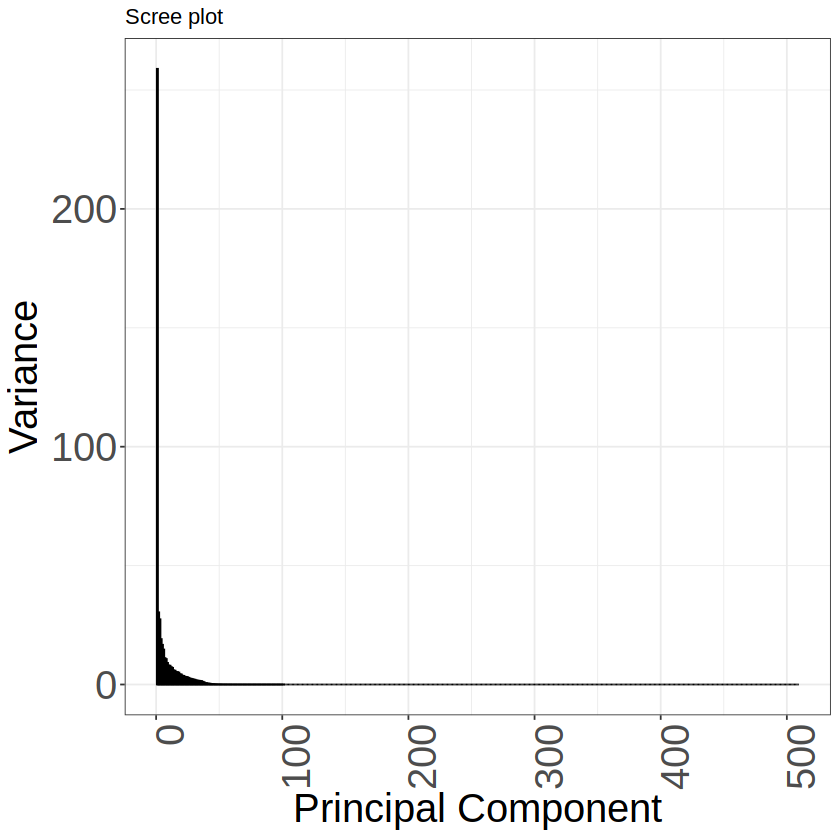

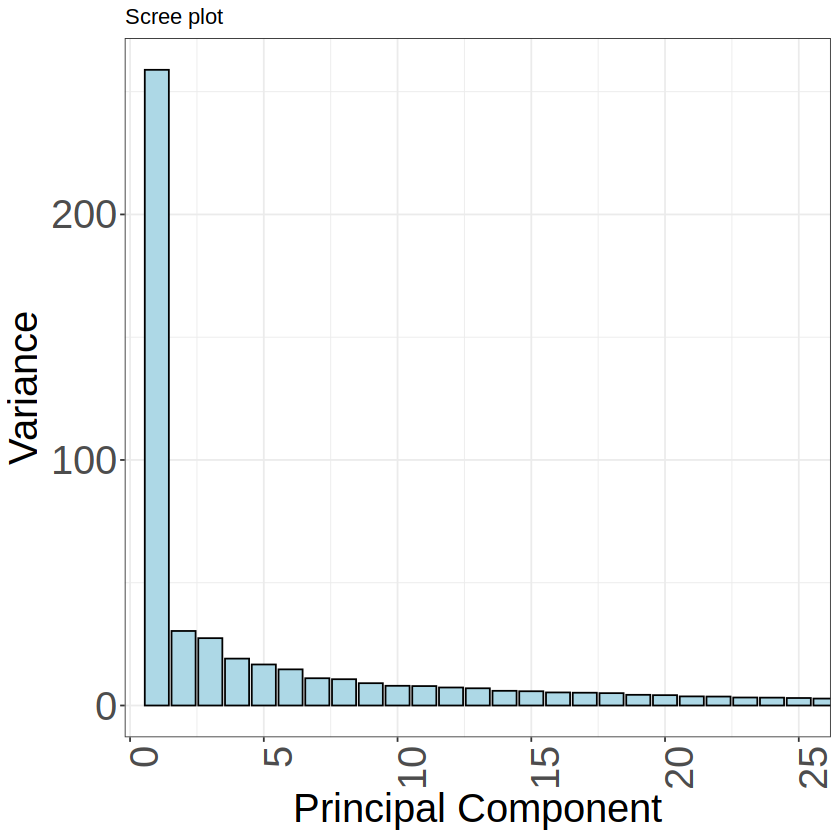

In [11]:
# scree plot to see how many components to keep
scree_data <- data.frame(
    PC = 1:length(pca$sdev),
    Variance = (pca$sdev)^2,
    Proportion = (pca$sdev)^2 / sum((pca$sdev)^2)
)
scree_plot <- (
    ggplot(scree_data, aes(x = PC, y = Variance, group = 1))
    + geom_bar(stat = "identity", fill = "lightblue", color = "black")
    + plot_themes
    + labs(
        title = "Scree plot",
        x = "Principal Component",
        y = "Variance"
    )
    + theme(
        axis.text.x = element_text(angle = 90, hjust = 1)
    )
)
scree_plot
# zoom in on the first 25 components
scree_plot_zoom <- (
    scree_plot
    + coord_cartesian(xlim = c(1, 25))
)
scree_plot_zoom

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


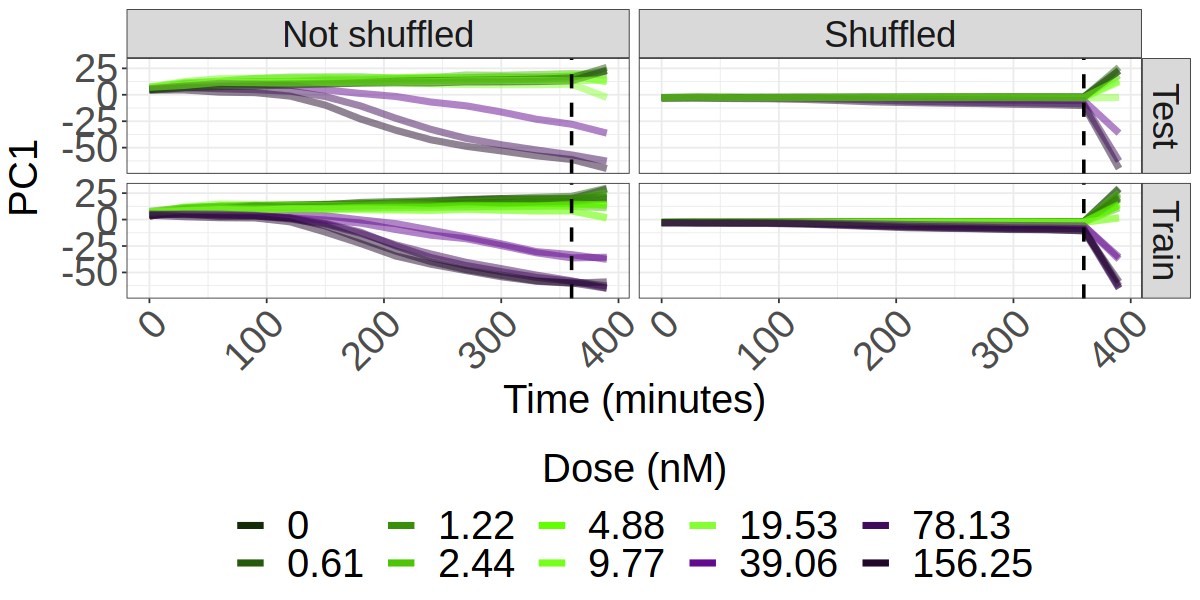

In [12]:
width <- 10
height <- 5
options(repr.plot.width=width, repr.plot.height=height)
# plot the pca
pca1_plot <- (
    ggplot(pca_df, aes(x = Metadata_Time, y = PC1, color = Metadata_dose, group = Group))
    + geom_line(aes(group = Group), alpha = 0.5, size = 2)
    + theme_minimal() 
    + facet_grid(Metadata_data_split ~ shuffled)
    + geom_vline(xintercept = (30*12), linetype = "dashed", color = "black", size = 1)
    + labs(x="Time (minutes)", y="PC1", color="Dose (nM)")
    + plot_themes
    + scale_color_manual(values = color_palette_dose)
    + dose_guides_color
    + theme(
        # axis tick labels
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1),
    )

)
ggsave(
    filename = "../figures/predicted_PC1.png",
    plot = pca1_plot,
    width = width,
    height = height,
    dpi = 600
)
pca1_plot

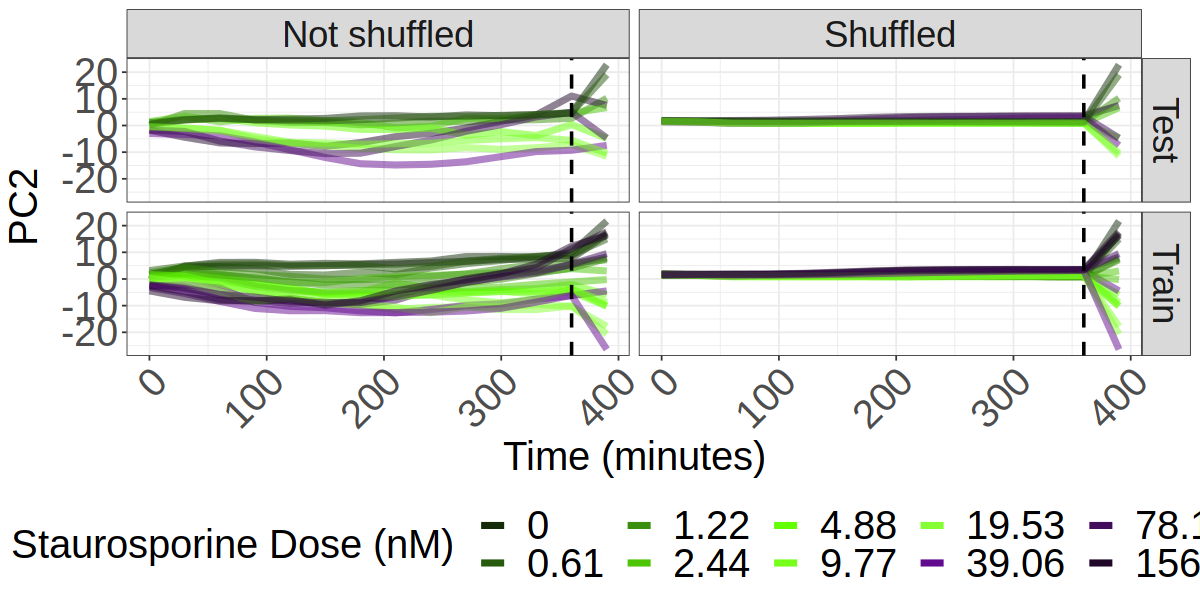

In [13]:
width <- 10
height <- 5
options(repr.plot.width=width, repr.plot.height=height)
# plot the pca
pca2_plot <- (
    ggplot(pca_df, aes(x = Metadata_Time, y = PC2, color = Metadata_dose, group = Group))
    + geom_line(aes(group = Group), alpha = 0.5, size = 2)
    + theme_minimal() 
    + facet_grid(Metadata_data_split ~ shuffled)
    + geom_vline(xintercept = (30*12), linetype = "dashed", color = "black", size = 1)
    + labs(x="Time (minutes)", y="PC2", color="Staurosporine Dose (nM)")
    + plot_themes
    + scale_color_manual(values = color_palette_dose)
    + guides(color = guide_legend( override.aes = list(size = 5, alpha = 1)))
    + theme(
        # axis tick labels
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1),
    )

)
ggsave(
    filename = "../figures/predicted_PC2.png",
    plot = pca2_plot,
    width = width,
    height = height,
    dpi = 600
)
pca2_plot

In [14]:
pca_df$Metadata_shuffle_plus_data_split <- paste(pca_df$shuffled, pca_df$Metadata_data_split)
pca_df$Metadata_Time <- paste0(pca_df$Metadata_Time, " min.")
pca_df$Metadata_Time <- gsub("390 min.", "Terminal", pca_df$Metadata_Time)
pca_df$Metadata_Time <- factor(
    pca_df$Metadata_Time, 
    levels = c(
        '0 min.',
        '30 min.',
        '60 min.',
        '90 min.',
        '120 min.',
        '150 min.',
        '180 min.',
        '210 min.',
        '240 min.',
        '270 min.',
        '300 min.',
        '330 min.',
        '360 min.',
        'Terminal'
    )
)

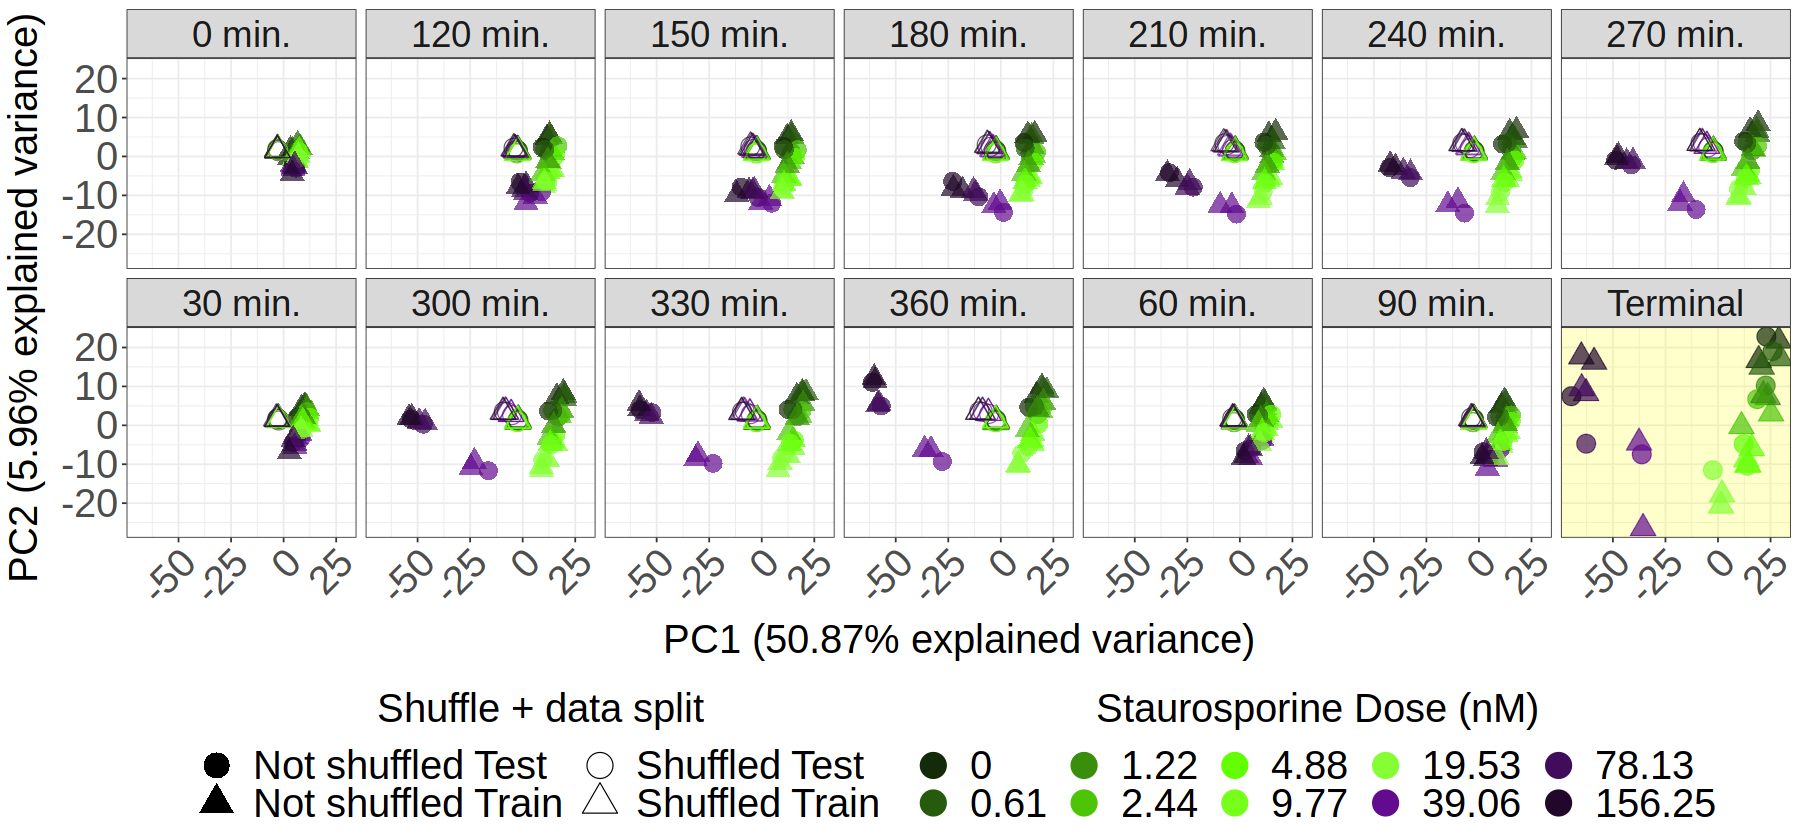

In [15]:
# Create background data for just the Terminal facet
terminal_bg_data <- pca_df %>%
  filter(Metadata_Time == "Terminal") %>%
  summarise(
    Metadata_Time = "Terminal",
    xmin = -Inf,
    xmax = Inf,
    ymin = -Inf,
    ymax = Inf
  ) %>%
  slice(1)  # Take only one row

# plot PCA1 vs PCA2 over time
width <- 15
height <- 7
options(repr.plot.width=width, repr.plot.height=height)
pca_over_time_plot <- (
    ggplot(pca_df, aes(x = PC1, y = PC2, color = Metadata_dose))
    # Add yellow background rectangle only for Terminal facet
    + geom_rect(data = terminal_bg_data, 
                aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax),
                fill = "yellow", alpha = 0.2, inherit.aes = FALSE)
    + geom_point(aes(shape = Metadata_shuffle_plus_data_split), size = 5, alpha = 0.7)
    + theme_minimal() 
    + facet_wrap( ~ Metadata_Time, ncol = 7)
    + labs(
        x=paste0("PC1 (", round(pca_df$PC1_var[1],2), "% explained variance)"),
        y=paste0("PC2 (", round(pca_df$PC2_var[1],2), "% explained variance)"),
        color="Staurosporine Dose (nM)"
        )
    + plot_themes
    + scale_color_manual(values = color_palette_dose)
    + scale_shape_manual(values = c(16, 17, 1, 2), name = "Shuffle + data split")
    + dose_guides_color
    + shuffle_guides_shape
    + theme(
        # axis tick labels
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1),
    )
)
ggsave(
    filename = "../figures/pca_over_time.png",
    plot = pca_over_time_plot,
    width = width,
    height = height,
    dpi = 600
)
pca_over_time_plot

## Single feature predictions

In [16]:

merged_results <- merged_results %>%
  mutate(Group = Metadata_Well) %>%
  arrange(Metadata_Well, Metadata_Time)
merged_results <- merged_results %>% arrange(Group)
head(merged_results)

Terminal_Cytoplasm_AreaShape_Area,Terminal_Cytoplasm_AreaShape_Compactness,Terminal_Cytoplasm_AreaShape_Eccentricity,Terminal_Cytoplasm_AreaShape_Extent,Terminal_Cytoplasm_AreaShape_FormFactor,Terminal_Cytoplasm_AreaShape_MajorAxisLength,Terminal_Cytoplasm_AreaShape_MedianRadius,Terminal_Cytoplasm_AreaShape_MinFeretDiameter,Terminal_Cytoplasm_AreaShape_Orientation,Terminal_Cytoplasm_AreaShape_Perimeter,⋯,Terminal_Nuclei_Texture_InverseDifferenceMoment_AnnexinV_3_03_256,Terminal_Nuclei_Texture_InverseDifferenceMoment_DNA_3_03_256,Terminal_Nuclei_Texture_SumAverage_AnnexinV_3_00_256,Terminal_Nuclei_Texture_SumAverage_DNA_3_01_256,Metadata_Well,Metadata_Time,Metadata_dose,shuffled,Metadata_data_split,Group
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<chr>,<chr>,<chr>
-0.2760859,-0.1420822,0.2366544,-0.21174194,-0.1219327,-0.2523864,-0.3957049,0.24924683,0.11755147,-0.2096947,⋯,0.4023901,0.3160771,0.03354997,0.6883655,C-02,0,0,Shuffled,Train,C-02
-0.2906410,-0.2693617,0.2366544,-0.09774379,-0.1361047,-0.2131060,-0.4219242,-0.09514793,0.12521138,-0.2560814,⋯,0.4505652,0.4414666,0.01237675,0.3531454,C-02,0,0,Not shuffled,Train,C-02
-0.2760859,-0.1420822,0.2366544,-0.21174194,-0.1180414,-0.2523864,-0.3957049,0.22493624,0.11755147,-0.2096947,⋯,0.4023901,0.3160771,0.03354997,0.7147091,C-02,30,0,Shuffled,Train,C-02
-0.2231399,-0.2490043,0.2366544,-0.07801766,-0.1379552,-0.1809200,-0.2767578,-0.03077541,0.07090512,-0.1919871,⋯,0.4410207,0.4567778,0.00886009,0.3223466,C-02,30,0,Not shuffled,Train,C-02
-0.2760859,-0.1420822,0.2366544,-0.21174194,-0.1170205,-0.2523864,-0.3957049,0.24245652,0.11755147,-0.2096947,⋯,0.4023901,0.3160771,0.03354997,0.7193898,C-02,60,0,Shuffled,Train,C-02
-0.2206355,-0.2543057,0.2366544,-0.06752930,-0.1382636,-0.1771583,-0.2566853,-0.02847020,0.06005876,-0.1856010,⋯,0.4481812,0.4564374,0.00827398,0.3380503,C-02,60,0,Not shuffled,Train,C-02


In [17]:
# single feature predictions
Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV_path <- file.path(
    "../results/Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV.parquet"
)

Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV <- arrow::read_parquet(Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV_path)

In [18]:
metadata_columns <- c("Metadata_Time", "Metadata_dose", "Metadata_Well", "shuffled", "Metadata_data_split")

In [19]:
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV <- subset_results[, colnames(subset_results) %in% c("Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV", metadata_columns)]
Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV <- actual_results[, colnames(actual_results) %in% c("Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV", metadata_columns)]


In [20]:

# merge the two dataframes on the columns "Metadata_Time" and "Metadata_dose" Metadata_Well
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV <- rbind(
    subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV, 
    Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV 
    )



In [21]:

subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_dose <- as.numeric(subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_dose)
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_dose <- factor(
    subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_dose, 
    levels = c(
        '0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
    )
)


In [22]:
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV <- subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV %>%
  mutate(Group = Metadata_Well) %>%
  arrange(Metadata_Well, Metadata_Time)
  


In [23]:
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV <- subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV %>% arrange(Group)
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_Time <- as.numeric(subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_Time) * 30


In [24]:

# add the data split
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV <- subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV %>%
  left_join(train_test_df, by = "Metadata_Well")

In [25]:

subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV <- subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV %>%
  mutate(Metadata_data_split = gsub("non_trained_pair", "train", Metadata_data_split))

In [26]:
# change the dose to a factor
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_dose <- as.factor(subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_dose)

In [27]:
# drop na in the data split column
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV <- subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV %>%
  filter(!is.na(Metadata_data_split)) %>%
  filter(!is.na(Metadata_Well)) %>%
  filter(!is.na(Metadata_Time)) %>%
  filter(!is.na(Metadata_dose))

subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_data_split <- gsub("non_Trained_pair", "Train", subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_data_split)
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$shuffled <- gsub("shuffled", "Shuffled", subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$shuffled)

subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$shuffled <- gsub("not_Shuffled", "Not shuffled", subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$shuffled)


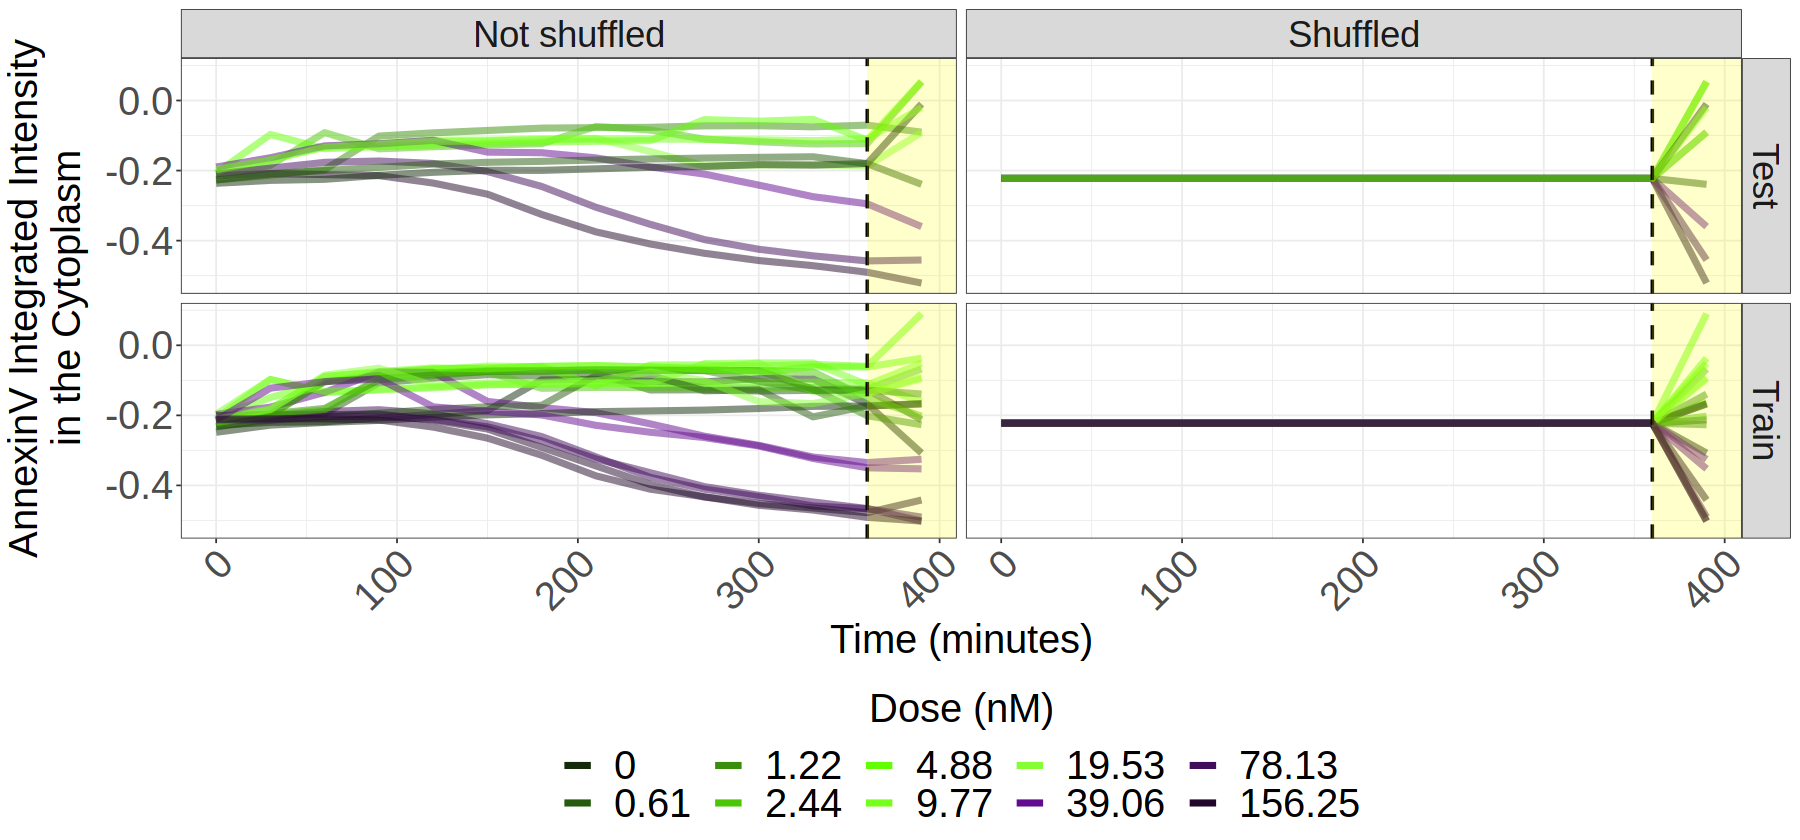

In [28]:
# plot the pca
Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV_plot <- (
    ggplot(subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV, aes(x = Metadata_Time, y = Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV, color = Metadata_dose, group = Group))
    + geom_line(aes(group = Group), alpha = 0.5, size = 2)
    + theme_minimal() 
    + facet_grid(Metadata_data_split ~ shuffled)

    + geom_vline(xintercept = (30*12), linetype = "dashed", color = "black", size = 1)

    + labs(x="Time (minutes)", y="AnnexinV Integrated Intensity\nin the Cytoplasm", color="Dose (nM)")
    + plot_themes
    + scale_color_manual(values = color_palette_dose)
    + dose_guides_color
    + theme(
        # axis tick labels
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1),
    )
    # add yellow background to the plot from x=360 to the end
    + annotate("rect", xmin = 360, xmax = Inf, ymin = -Inf, ymax = Inf, alpha = 0.2, fill = "yellow")


)
ggsave(
    filename = "../figures/AnnexinV_Integrated_Intensity_in_the_Cytoplasm.png",
    plot = Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV_plot,
    width = width,
    height = height,
    dpi = 600
)
Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV_plot

### Workflow figure

In [29]:
# read and rasterize the workflow figure
workflow_figure_path <- file.path(
    "../external_images/timelapse_apoptosis_ML_strategy_figure.png"
)
workflow_figure <- png::readPNG(workflow_figure_path)
workflow_figure_raster <- grid::rasterGrob(workflow_figure, interpolate = TRUE)
workflow_figure_raster <- as.ggplot(
    workflow_figure_raster
) + 
    theme_void() +
    theme(
        plot.margin = margin(0, 0, 0, 0)
    )
# cut down on the whitespace around the image
workflow_figure_raster <- workflow_figure_raster + 
    theme(
        plot.margin = margin(0, 0, -1, -1) # left, right, top, bottom
    )

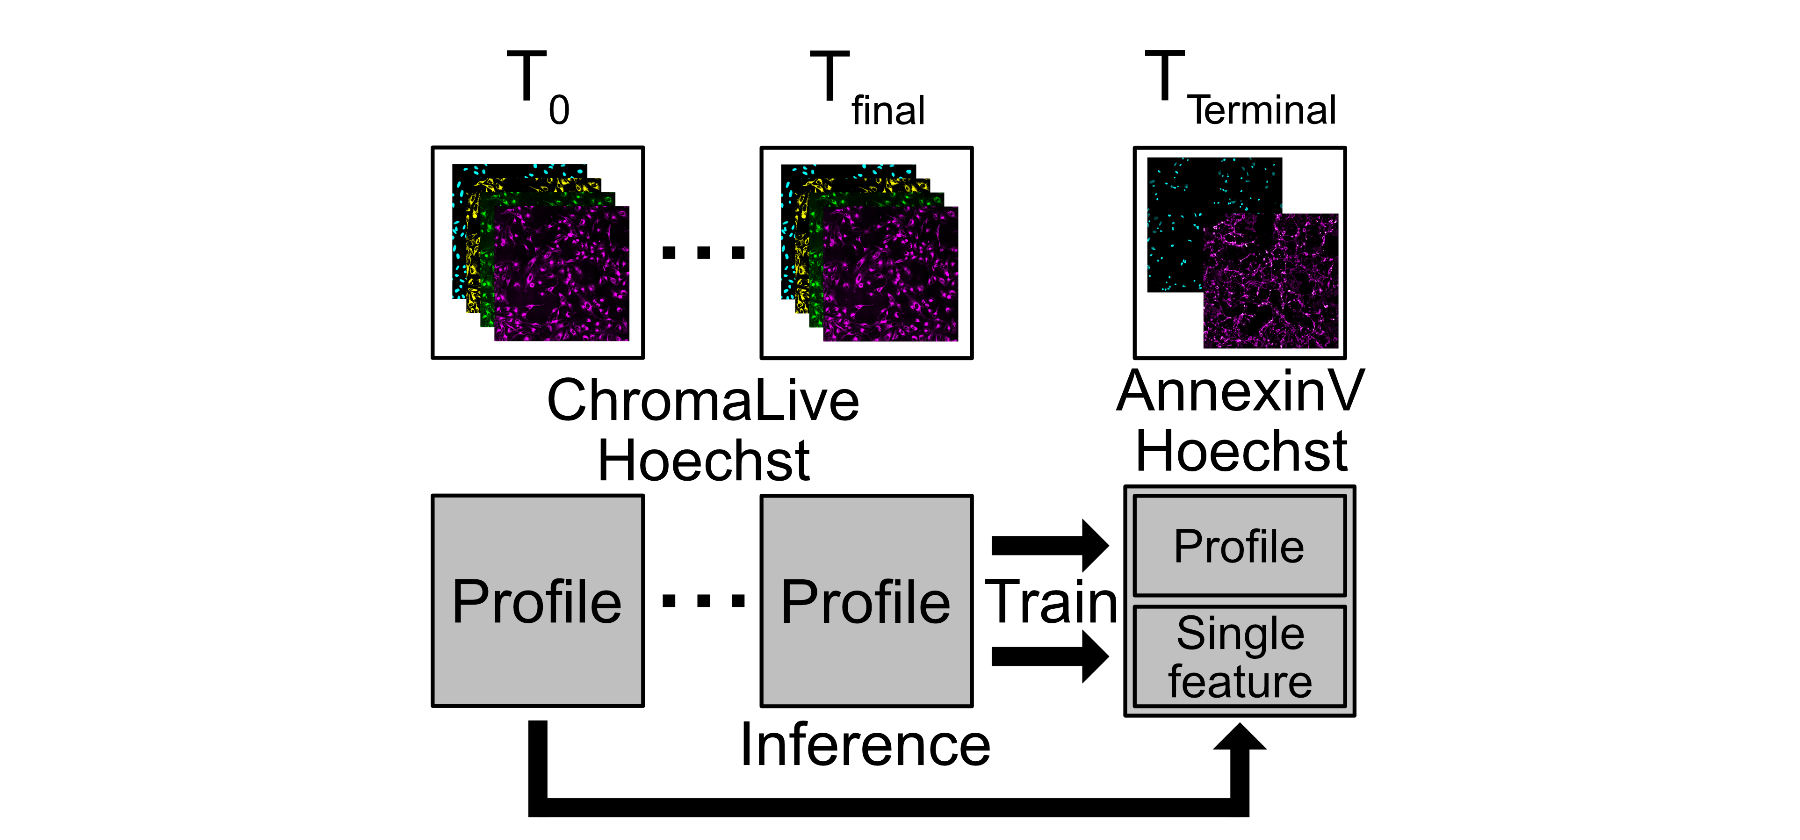

In [30]:
workflow_figure_raster

### Patchwork for a final figure

In [31]:
Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV_plot <- Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV_plot + theme(legend.position = "none")
pca1_plot <- pca1_plot + theme(legend.position = "none")

## Final figure

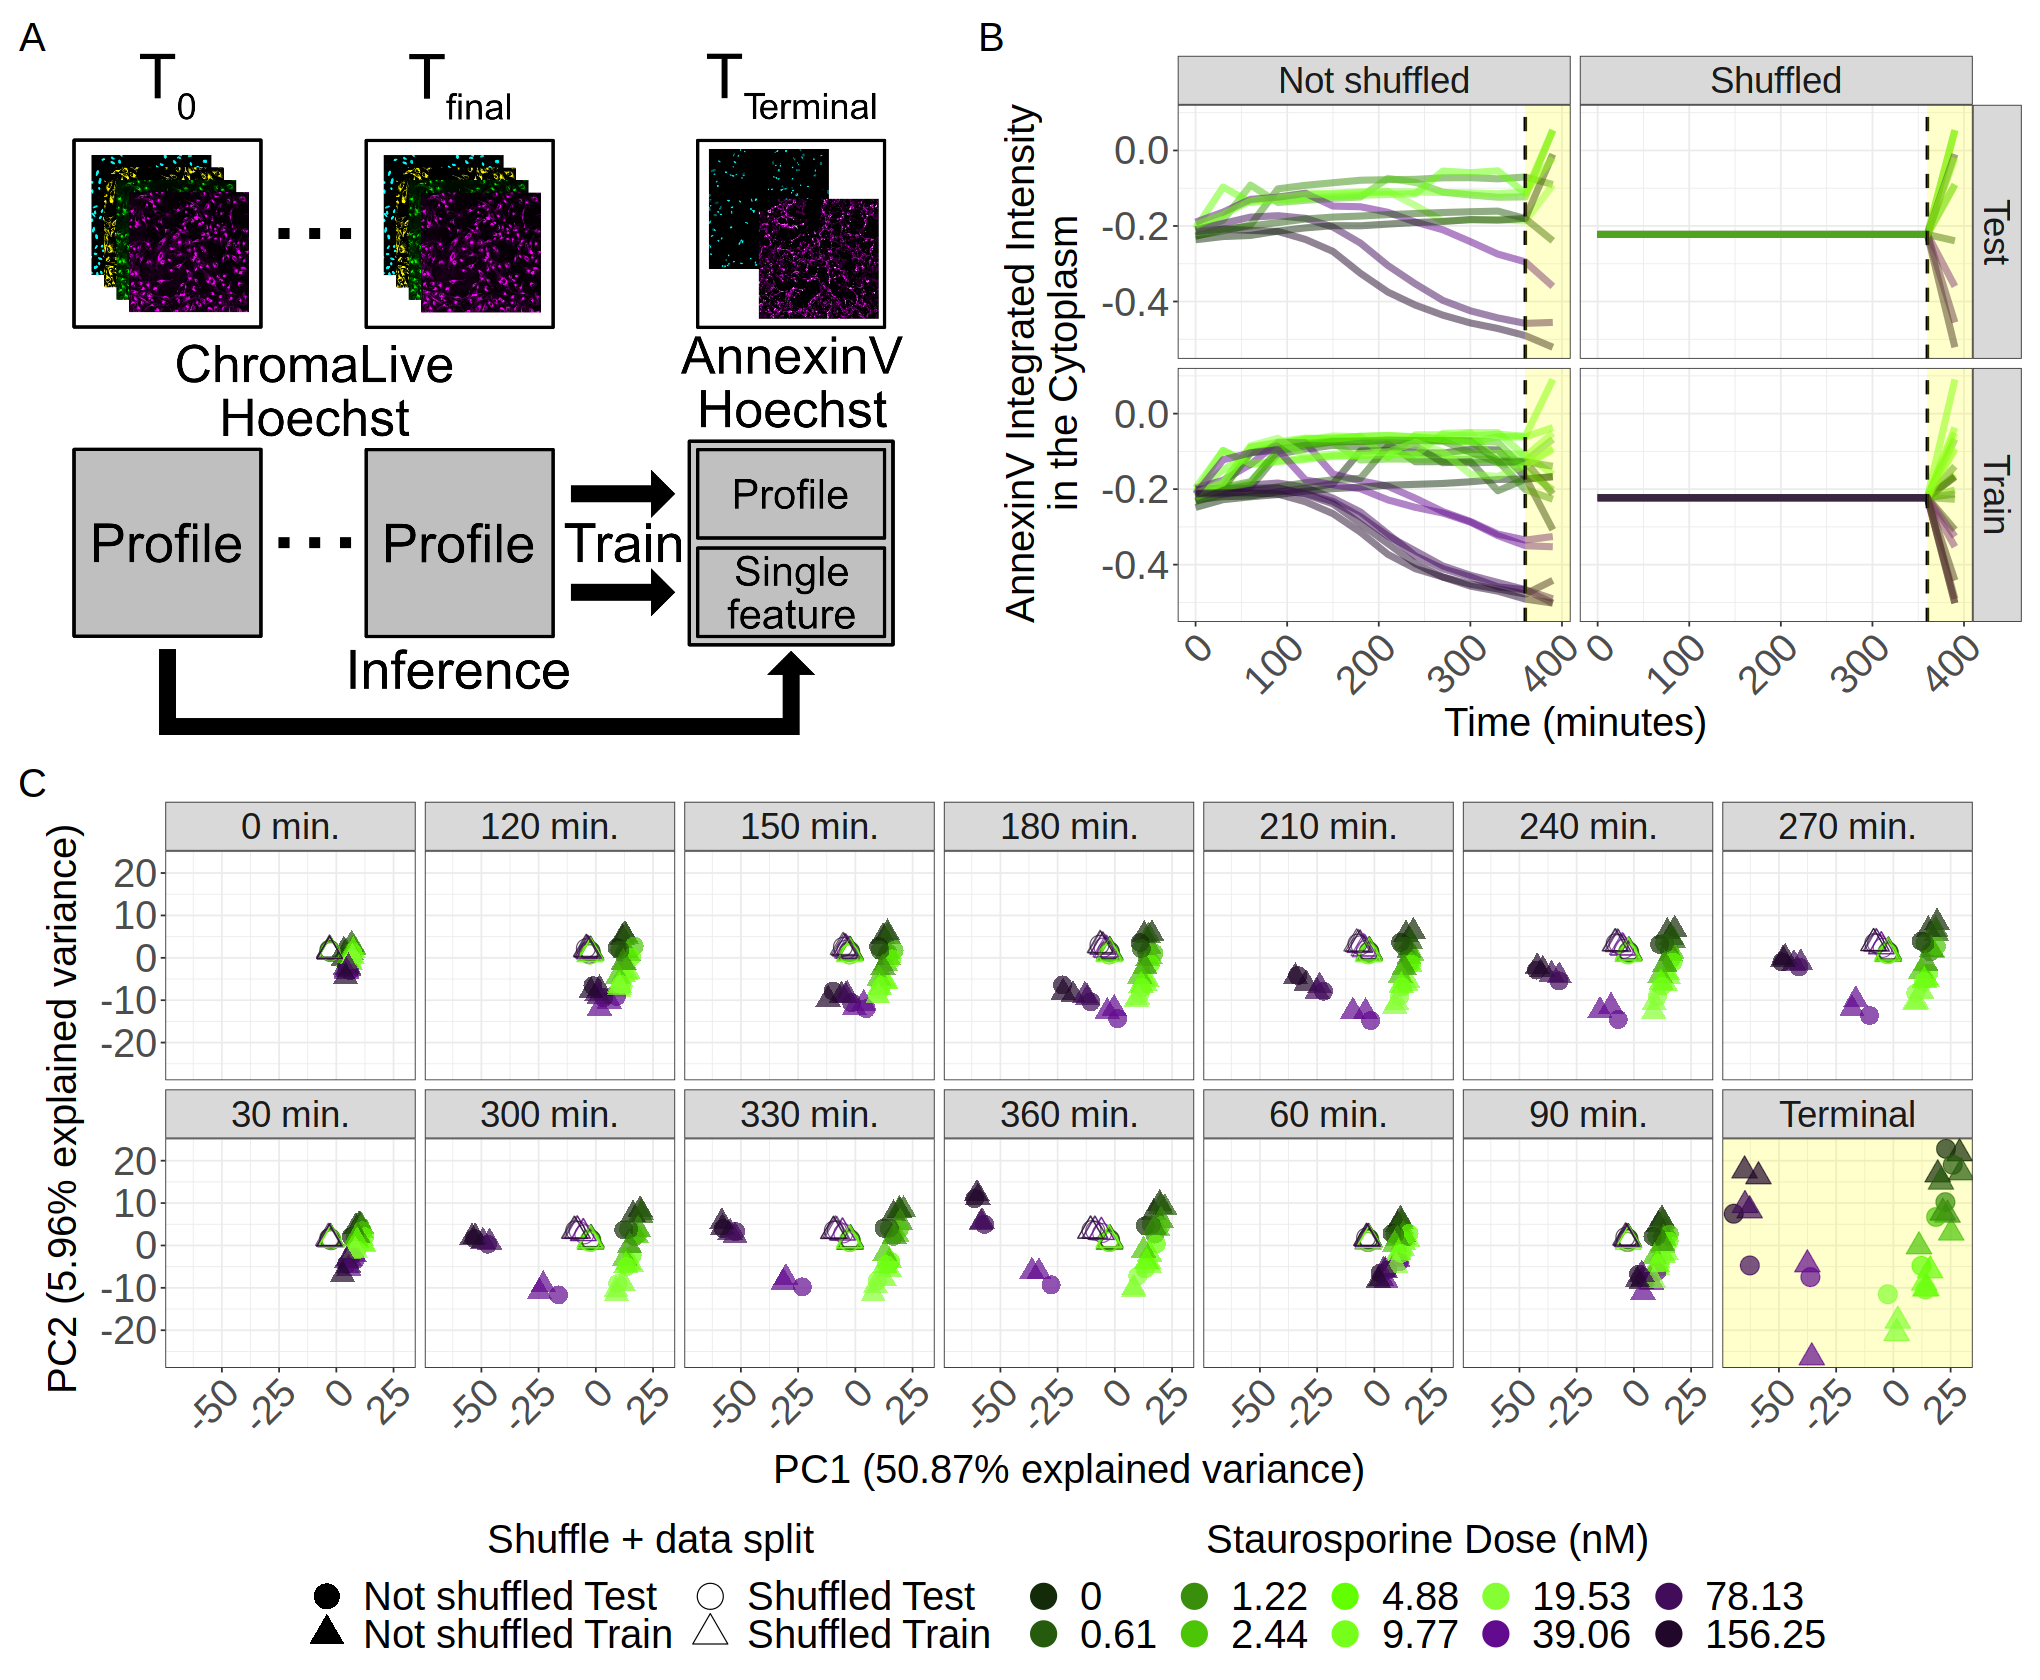

In [32]:
layout <- "
AABB
CCCC
"
height <- 14
width <- 17
options(repr.plot.width=width, repr.plot.height=height)
final_plot <- (
    # workflow_figure_raster
    # tight layout
    wrap_elements(
        full = workflow_figure_raster
    )
    + Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV_plot 
     
    + pca_over_time_plot
    + plot_layout(design = layout)
    + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 24))
)
ggsave(
    filename = "../figures/final_predicted_terminal_profiles_from_all_time_points.png",
    plot = final_plot,
    width = width,
    height = height,
    dpi = 600
)
final_plot